In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
DATASET_PATH = './data/beer_profile_and_ratings.csv'

TARGET_COLUMN = 'review_overall'

NUMERICAL_FEATURES = []
CATEGORICAL_FEATURES = ['Style']

TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"\nЦелевая переменная: {TARGET_COLUMN}"
      f"\nРазмер тестовой выборки: {TEST_SIZE}"
      f"\nRANDOM_STATE: {RANDOM_STATE}")
print(f"Числовые признаки ({len(NUMERICAL_FEATURES)}): {NUMERICAL_FEATURES}")
print(f"Категориальные признаки ({len(CATEGORICAL_FEATURES)}): {CATEGORICAL_FEATURES}")


Целевая переменная: review_overall
Размер тестовой выборки: 0.2
RANDOM_STATE: 42
Числовые признаки (0): []
Категориальные признаки (1): ['Style']


In [13]:
df = pd.read_table(DATASET_PATH, delimiter=',')
def trim_style(style):
    if '-' in style:
        return style.split('-')[0].strip()
    return style

df['Style'] = df['Style'].apply(trim_style)
unique_styles = df['Style'].unique()

# df.head()
# df.info()

In [14]:
from scipy.stats import chi2

num_features = ['ABV', 'Min IBU', 'Max IBU']

def mahalanobis_dist(df, features):
    X = df[features].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)  # Используем псевдообратную матрицу если обычная вырождена
    
    deviations = X - mean
    distances = np.sqrt(np.sum(deviations.dot(cov_inv) * deviations, axis=1))
    return distances

# Вычисляем расстояния
distances = mahalanobis_dist(df, num_features)

threshold = chi2.ppf(0.95, df=len(num_features))  # 95% доверительный интервал

outliers_mask = distances > np.sqrt(threshold)
outliers = df[outliers_mask]

original_size = len(df)
df_clean = df[~outliers_mask]

df = df_clean.copy()

In [15]:
initial_rows = len(df)
df.dropna(subset=[TARGET_COLUMN], inplace=True)
rows_after_dropna = len(df)
print(f"\tУдалено {initial_rows - rows_after_dropna} строк с отсутствующим значением в '{TARGET_COLUMN}'.")

	Удалено 0 строк с отсутствующим значением в 'review_overall'.


In [16]:
features_to_use = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
X = df[features_to_use]
y = df[TARGET_COLUMN]
print(f"\tДанные разделены на признаки (X) формы {X.shape} и целевую переменную (y) формы {y.shape}.")

	Данные разделены на признаки (X) формы (2951, 1) и целевую переменную (y) формы (2951,).


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"\nДанные разделены на обучающую и тестовую выборки:")
print(f"Обучающая выборка X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Тестовая выборка X_test: {X_test.shape}, y_test: {y_test.shape}")


Данные разделены на обучающую и тестовую выборки:
Обучающая выборка X_train: (2360, 1), y_train: (2360,)
Тестовая выборка X_test: (591, 1), y_test: (591,)


In [18]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
print("\tСоздан пайплайн для числовых признаков (SimpleImputer(median) -> StandardScaler).")

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
print("\tСоздан пайплайн для категориальных признаков (SimpleImputer(most_frequent) -> OneHotEncoder).")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, NUMERICAL_FEATURES),
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='drop'
)
print("\tСоздан ColumnTransformer для применения пайплайнов к соответствующим колонкам.")

	Создан пайплайн для числовых признаков (SimpleImputer(median) -> StandardScaler).
	Создан пайплайн для категориальных признаков (SimpleImputer(most_frequent) -> OneHotEncoder).
	Создан ColumnTransformer для применения пайплайнов к соответствующим колонкам.


In [19]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Обучение модели
model_pipeline.fit(X_train, y_train)

# Предсказание
y_pred = model_pipeline.predict(X_test)
print(f"Предсказания выполнены. Пример первых 5 предсказаний: {y_pred[:5]}")
print(f"Пример первых 5 фактических значений: {y_test.values[:5]}")

# 10. Оценка модели
print("\nОценка качества модели:")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Coefficient of Determination (R²): {r2:.4f}")

Предсказания выполнены. Пример первых 5 предсказаний: [3.95205041 3.78704349 3.78175036 3.94775734 3.78175036]
Пример первых 5 фактических значений: [3.84642 2.75    3.5225  3.75    4.3    ]

Оценка качества модели:
Mean Squared Error (MSE): 0.1586
Root Mean Squared Error (RMSE): 0.3983
Mean Absolute Error (MAE): 0.2851
Coefficient of Determination (R²): 0.3248


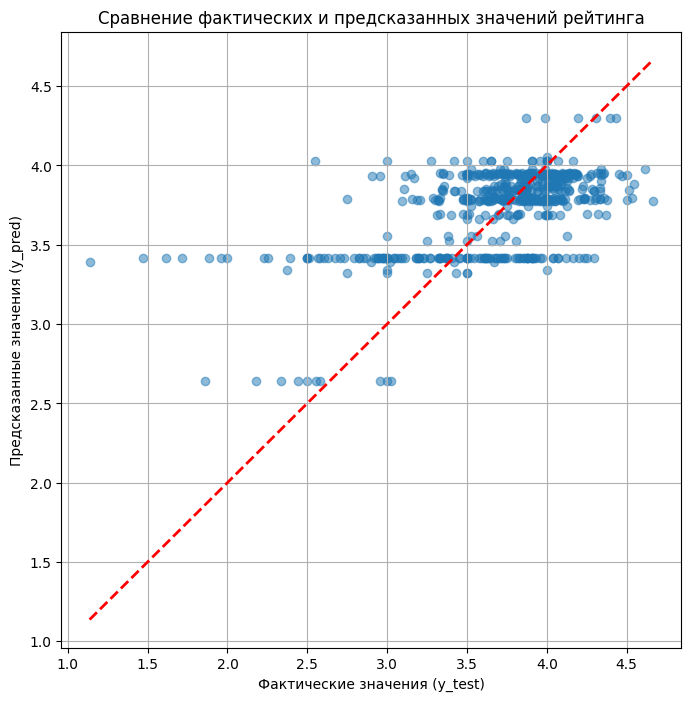

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Диагональная линия y=x
plt.xlabel("Фактические значения (y_test)")
plt.ylabel("Предсказанные значения (y_pred)")
plt.title("Сравнение фактических и предсказанных значений рейтинга")
plt.grid(True)
plt.show()

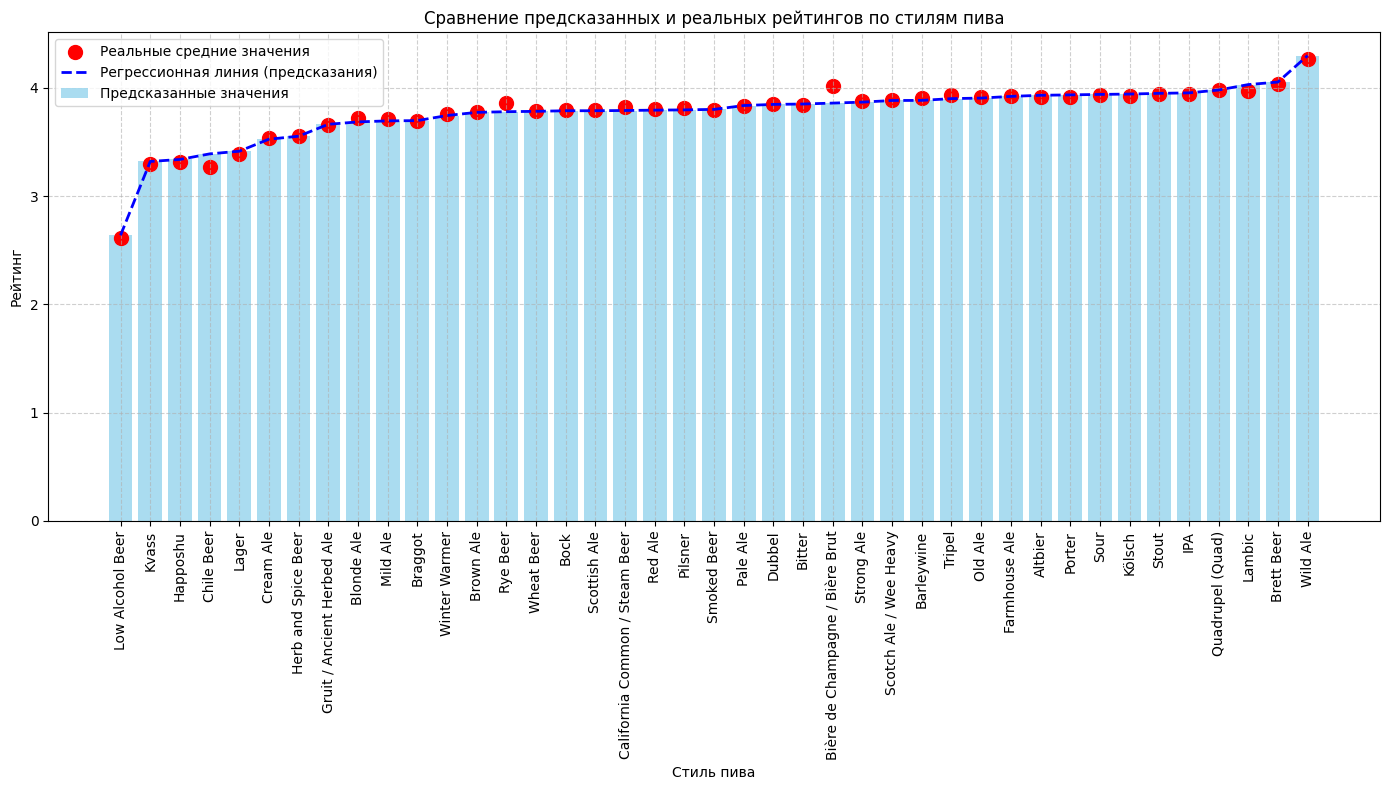


Коэффициенты регрессии для каждого стиля:
Altbier: 0.1621
Barleywine: 0.1150
Bitter: 0.0816
Bière de Champagne / Bière Brut: 0.0901
Blonde Ale: -0.0835
Bock: 0.0194
Braggot: -0.0717
Brett Beer: 0.2845
Brown Ale: 0.0045
California Common / Steam Beer: 0.0217
Chile Beer: -0.3788
Cream Ale: -0.2431
Dubbel: 0.0780
Farmhouse Ale: 0.1521
Gruit / Ancient Herbed Ale: -0.1057
Happoshu: -0.4302
Herb and Spice Beer: -0.2157
IPA: 0.1844
Kvass: -0.4488
Kölsch: 0.1734
Lager: -0.3542
Lambic: 0.2609
Low Alcohol Beer: -1.1301
Mild Ale: -0.0739
Old Ale: 0.1363
Pale Ale: 0.0676
Pilsner: 0.0275
Porter: 0.1659
Quadrupel (Quad): 0.2107
Red Ale: 0.0250
Rye Beer: 0.0106
Scotch Ale / Wee Heavy: 0.1140
Scottish Ale: 0.0196
Smoked Beer: 0.0320
Sour: 0.1702
Stout: 0.1801
Strong Ale: 0.0990
Tripel: 0.1315
Wheat Beer: 0.0141
Wild Ale: 0.5285
Winter Warmer: -0.0246

Intercept (базовый рейтинг): 3.7676

Сравнение предсказанных и реальных значений:
                              Style  Predicted_Rating  Actual_Mean_Ra

In [ ]:
plt.figure(figsize=(14, 8))

style_encoder = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
styles = style_encoder.categories_[0]

style_df = pd.DataFrame({'Style': styles})
X_style = style_df[['Style']]
y_pred_style = model_pipeline.predict(X_style)

real_means = df.groupby('Style')['review_overall'].mean().reindex(styles)

sorted_idx = np.argsort(y_pred_style)
styles_sorted = styles[sorted_idx]
y_pred_sorted = y_pred_style[sorted_idx]
real_means_sorted = real_means.values[sorted_idx]

bars = plt.bar(range(len(styles_sorted)), y_pred_sorted, color='skyblue', alpha=0.7, label='Предсказанные значения')

plt.scatter(range(len(styles_sorted)), real_means_sorted, color='red', s=100, label='Реальные средние значения')

plt.plot(range(len(styles_sorted)), y_pred_sorted, color='blue', linestyle='--', linewidth=2, label='Регрессионная линия (предсказания)')

plt.xticks(range(len(styles_sorted)), styles_sorted, rotation=90)
plt.xlabel('Стиль пива')
plt.ylabel('Рейтинг')
plt.title('Сравнение предсказанных и реальных рейтингов по стилям пива')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

coefficients = model_pipeline.named_steps['regressor'].coef_
intercept = model_pipeline.named_steps['regressor'].intercept_

print("\nКоэффициенты регрессии для каждого стиля:")
for style, coef in zip(styles, coefficients):
    print(f"{style}: {coef:.4f}")
print(f"\nIntercept (базовый рейтинг): {intercept:.4f}")

comparison_df = pd.DataFrame({
    'Style': styles,
    'Predicted_Rating': y_pred_style,
    'Actual_Mean_Rating': real_means.values,
    'Difference': y_pred_style - real_means.values
})
print("\nСравнение предсказанных и реальных значений:")
print(comparison_df.sort_values('Predicted_Rating', ascending=False))